# **`1b` scenarios 0a, 1b, 2c, 3d, 4e, 5f**

In [1]:
import os ; import pathlib as pl ; from pprint import pformat ; import flopy ; import git ; import matplotlib.pyplot as plt
import numpy as np; from flopy.plot.styles import styles ; import pathlib; from pathlib import Path; import pandas as pd
import modflow_devtools.misc 
from modflow_devtools.misc import get_env, timed    # pip install modflow_devtools
write = get_env("WRITE", True) ; run = get_env("RUN", True) ;  plot = get_env("PLOT", True)
plot_show = get_env("PLOT_SHOW", True) ; plot_save = get_env("PLOT_SAVE", True)

In [2]:
example_name = "ex-gwt-mt3dms-p02"

In [3]:
parameters = {"ex-gwt-mt3dms-p02a": {"sorption": "freundlich","Kf": 0.3,"a": 0.7,},        # a
              "ex-gwt-mt3dms-p02b": {"sorption": "langmuir","Kl": 100.0,"S": 0.003,},      # b
              "ex-gwt-mt3dms-p02c": {"beta": 0.0,},
              "ex-gwt-mt3dms-p02d": {"beta": 0.002,},
              "ex-gwt-mt3dms-p02e": {"beta": 0.01,},
              "ex-gwt-mt3dms-p02f": {"beta": 20.0,},}
parameter_units = {"beta": "$s^{-1}$","sorption": "text string","Kf": r"$\mu g L g^{} mg^{-1}$","a": "unitless","Kl": "$L mg^{-1}$","S": r"$\mu g g^{-1}$",}  
length_units = "centimeters" ; time_units = "seconds"
exe_name_mt = 'E:\\15_REPOS\\00_BETAMI\\bin\\mt3d-usgs_1.1.0_64'
exe_name_mu = 'E:\\15_REPOS\\00_BETAMI\\bin\\mf6'
current_directory = os.getcwd();  print(current_directory)

E:\15_REPOS\00_BETAMI\98_Plus\02_MT3D


In [4]:
path = pathlib.Path('E:\\15_REPOS\\00_BETAMI\\98_Plus\\02_MT3D')
path.mkdir(parents=True, exist_ok=True); os.chdir(path); current_directory = os.getcwd()
directory_name = 'A_p02_V02_scenarios(01-05)'    ; workspace = os.path.join('.', directory_name)
if os.path.isdir(workspace) is False:
    os.mkdir(workspace) 
output_folder = Path('A_p02_V02_scenarios(01-05)') ; output_folder.mkdir(exist_ok=True)

In [5]:
nper = 2            # Number of periods
nlay = 1            # Number of layers
nrow = 1            # Number of rows
ncol = 101          # Number of columns
period1 = 160       # Length of period 1 ($s$)
period2 = 1340      # Length of period 2 ($s$)
perlen = [period1, period2]
delta_time = 1.0    # Length of time steps ($s$)
delr = 0.16  
delc = 0.16  
top = 1.0  
botm = 0                          # Layer bottom elevation ($cm$)
velocity = 0.1                    # Velocity ($cm s^{-1}$)
hydraulic_conductivity = 0.01     # Hydraulic conductivity ($cm s^{-1}$)
porosity = 0.37                   # Porosity of mobile domain (unitless)
bulk_density = 1.587              # Bulk density ($g cm^{-3}$)
distribution_coefficient = 0.933  # Distribution coefficient ($cm^3 g^{-1}$)
dispersivity = 1.0                # Longitudinal dispersivity ($cm$)
source_concentration = 0.05       # Source concentration (unitless)
initial_concentration = 0.0       # Initial concentration (unitless)

In [6]:
specific_discharge = velocity * porosity  
inflow_rate        = specific_discharge * delc * (top - botm)      
system_length      = ncol * delr          
wel_spd            = {0: [[(0, 0, 0), inflow_rate, source_concentration],],1: [[(0, 0, 0), inflow_rate, 0.0],],}

specific_discharge, inflow_rate,  system_length

(0.037, 0.00592, 16.16)

In [7]:
def build_mf6gwf(sim_folder):
    print(f"Building mf6gwf model...{sim_folder}")
    name    = "flow"
    sim_ws  = os.path.join(workspace, sim_folder, "mf6gwf")
    sim     = flopy.mf6.MFSimulation(sim_name=name, sim_ws=sim_ws, exe_name="mf6")
    tdis_ds = ((period1, int(period1 / delta_time), 1.0),(period2, int(period2 / delta_time), 1.0))
    flopy.mf6.ModflowTdis         (sim, nper=nper, perioddata=tdis_ds, time_units=time_units)                    ; htol = 1.0e-8
    flopy.mf6.ModflowIms          (sim, print_option="summary", outer_dvclose=htol, inner_dvclose=htol)
    gwf = flopy.mf6.ModflowGwf    (sim, modelname=name, save_flows=True)  # hobj = gwf.output.head()      ; hds= hobj.get_data()
    dis = flopy.mf6.ModflowGwfdis (gwf,nlay=nlay,nrow=nrow,ncol=ncol,delr=delr,delc=delc,top=top,botm=botm)    
    flopy.mf6.ModflowGwfnpf       (gwf,save_specific_discharge=True,save_saturation=True,icelltype=0,k=hydraulic_conductivity)
    flopy.mf6.ModflowGwfic        (gwf, strt=1.0)
    flopy.mf6.ModflowGwfchd       (gwf, stress_period_data=[[(0, 0, ncol - 1), 1.0]])
    flopy.mf6.ModflowGwfwel       (gwf,stress_period_data=wel_spd,pname="WEL-1",auxiliary=["CONCENTRATION"],)
    head_filerecord = f"{name}.hds"
    budget_filerecord = f"{name}.bud"
    flopy.mf6.ModflowGwfoc  (gwf,head_filerecord=head_filerecord,budget_filerecord=budget_filerecord,saverecord=[("HEAD", "ALL"), ("BUDGET", "ALL")])
    return sim

def build_mf6gwt(sim_folder, sorption=None, Kf=None, a=None, Kl=None, S=None, beta=None):
    print(f"Building mf6gwt model...{sim_folder}")
    name    = "trans"
    sim_ws  = os.path.join(workspace, sim_folder, "mf6gwt")
    sim     = flopy.mf6.MFSimulation(sim_name=name, sim_ws=sim_ws, exe_name="mf6")
    tdis_ds = ((period1, int(period1 / delta_time), 1.0),(period2, int(period2 / delta_time), 1.0),)
    flopy.mf6.ModflowTdis(sim, nper=nper, perioddata=tdis_ds, time_units=time_units)                     ; ctol = 1.0e-8
    flopy.mf6.ModflowIms(sim,linear_acceleration="bicgstab",print_option="summary",outer_dvclose=ctol,inner_dvclose=ctol,)
    gwt = flopy.mf6.ModflowGwt(sim, modelname=name, save_flows=True)
    flopy.mf6.ModflowGwtdis(gwt,length_units=length_units,nlay=nlay,nrow=nrow,ncol=ncol,delr=delr,delc=delc,top=top,botm=botm)
    flopy.mf6.ModflowGwtic(gwt, strt=initial_concentration)

    distcoef = None
    if Kf is not None:
        distcoef = Kf
    if Kl is not None:
        distcoef = Kl
    sp2 = None
    if a is not None:
        sp2 = a
    if S is not None:
        sp2 = S
    volfracim = 0.0
    if beta is not None:
        if beta > 0:
            volfracim = bulk_density / (bulk_density + porosity)

    flopy.mf6.ModflowGwtmst(gwt,porosity=porosity / (1.0 - volfracim),
                            bulk_density=bulk_density if sorption else None,sorption=sorption,distcoef=distcoef,sp2=sp2)
    flopy.mf6.ModflowGwtadv(gwt, scheme="UPSTREAM")
    flopy.mf6.ModflowGwtdsp(gwt, xt3d_off=True, alh=dispersivity, ath1=dispersivity)
    
    if beta is not None:
        if beta > 0:
            porosity_im = bulk_density / volfracim          ; flopy.mf6.ModflowGwtist(gwt, volfrac=volfracim, porosity=porosity_im, zetaim=beta)
    pd = [ ("GWFHEAD", "../mf6gwf/flow.hds", None),("GWFBUDGET", "../mf6gwf/flow.bud", None)]
    flopy.mf6.ModflowGwtfmi(gwt, packagedata=pd)            ; sourcerecarray = [["WEL-1", "AUX", "CONCENTRATION"]]
    flopy.mf6.ModflowGwtssm(gwt, sources=sourcerecarray)    ; obs_data = {f"{name}.obs.csv": [("X008", "CONCENTRATION", (0, 0, 50)),],}  # !!!!
    obs_package = flopy.mf6.ModflowUtlobs(gwt, digits=10    , print_input=True, continuous=obs_data)
    flopy.mf6.ModflowGwtoc(gwt,budget_filerecord=f"{name}.cbc",concentration_filerecord=f"{name}.ucn",
                           saverecord=[("CONCENTRATION", "ALL"), ("BUDGET", "LAST")],
                           printrecord=[("CONCENTRATION", "LAST"), ("BUDGET", "LAST")])
    return sim
def build_models(sim_name, **kwargs):
    sim_mf6gwf = build_mf6gwf(sim_name) ; sim_mf6gwt = build_mf6gwt(sim_name, **kwargs)
    return sim_mf6gwf, sim_mf6gwt 
    
def write_models(sims, silent=True):
    sim_mf6gwf, sim_mf6gwt = sims       ; sim_mf6gwf.write_simulation(silent=silent)  ; sim_mf6gwt.write_simulation(silent=silent)
@timed
def run_models(sims, silent=True):
    sim_mf6gwf, sim_mf6gwt = sims 
    success, buff = sim_mf6gwf.run_simulation(silent=silent, report=True)  ; assert success, pformat(buff)
    success, buff = sim_mf6gwt.run_simulation(silent=silent, report=True)  ; assert success, pformat(buff)

In [8]:
def scenario(idx, silent=True):
    key = list(parameters.keys())[idx]
    parameter_dict = parameters[key]
    sims = build_models(key, **parameter_dict)
    if write:
        write_models(sims, silent=silent)
    if run:
        run_models(sims, silent=silent)

## **Scenarios**

In [9]:
scenario(1) 

Building mf6gwf model...ex-gwt-mt3dms-p02b
Building mf6gwt model...ex-gwt-mt3dms-p02b
run_models took 3009.51 ms


In [10]:
# build_mf6gwf('ex-gwt-mt3dms-p02f')    ; build_mf6gwt('ex-gwt-mt3dms-p02f')
# hobj = sim_mf6gwf.output.head()    ; hds= hobj.get_data()   ; print('H (2000d)=', hds.shape)

# **ex-gwt-mt3dms-p02` a,b,c,d,e`**

In [11]:
sim_ws = os.path.join (workspace, 'ex-gwt-mt3dms-p02b')    
fname = os.path.join  (sim_ws,    'mf6gwt' ,  'trans.obs.csv')   ; mf6gwt_ra = flopy.utils.Mf6Obs(fname).data
mf6conc = mf6gwt_ra["X008"] / source_concentration               ; then = pd.DataFrame(mf6conc)  

In [12]:
print(mf6gwt_ra.shape)

(1500,)


In [13]:
fname = os.path.join(sim_ws, 'mf6gwt', 'trans.UCN')  # ;ucnobj = flopy.utils.UcnFile(fname)  # ; times = np.array(ucnobj.get_times()) # err ...

In [14]:
fname  = os.path.join  (sim_ws,    'mf6gwf'  ,  'flow.hds')  
hdobj  = flopy.utils.HeadFile(fname)    
heads  = hdobj.get_data()            ; print('heads=',heads.shape, 'perlen=',perlen)       
heads2 = heads[0,:,:]                 

heads= (1, 1, 101) perlen= [160, 1340]


# **0a, 1b, 2c, 3d, 4e**

In [15]:
then.to_csv(output_folder /                               "scenario(1b)_C.csv")
then = pd.DataFrame(heads2) ; then.to_csv(output_folder / "scenario(1b)_H.csv") 

In [16]:
model_time = np.cumsum(perlen); print(model_time);  # plt.figure(figsize=(3,1)) 
# plt.plot( [model_time[0],model_time[0]],  [0, 1],   '--k') ; plt.plot( [model_time[1],model_time[1]],  [0, 1],   '--k') 

[ 160 1500]


Text(0, 0.5, 'Concentration')

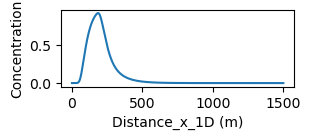

In [17]:
plt.figure(figsize=(3, 1))  ; plt.plot(mf6conc)   ; plt.xlabel('Distance_x_1D (m)')   ; plt.ylabel('Concentration') 

In [18]:
# obs_data